In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import statsmodels.api as sm
import RMA

In [2]:
import matplotlib as mpl

In [3]:
%matplotlib inline

In [818]:
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.serif'] = 'Times'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['text.usetex']=True
mpl.rcParams['figure.figsize'] = (10,7.15)
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0
mpl.rcParams['figure.titlesize'] = 28
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['patch.linewidth'] = 0.5

In [5]:
df = pd.read_csv('../data/natureMcNab2008.csv')

In [6]:
df.columns

Index([u'Order', u'Family', u'Genus', u'Species', u'Genus Species',
       u'McNab Name', u'Mass (g)', u'BMR (W)', u'BMR (kJ/h)',
       u'Temperature (C)', u'Notes', u'Reference', u'Food', u'Climate',
       u'Habitat', u'Substrate', u'Torpor', u'Islands', u'Mountains',
       u'Tree Name', u'Notes.1'],
      dtype='object')

In [7]:
df['Temperature (C)'].min(),df['Temperature (C)'].max()

(30.4, 40.1)

In [8]:
data = pd.DataFrame()
data_noT = pd.DataFrame()

In [9]:
data['Mass'] = df['Mass (g)']
data_noT['Mass'] = df['Mass (g)']

data['BMRW'] = df['BMR (W)']
data_noT['BMRW'] = df['BMR (W)']

data['BMRkjh'] = df['BMR (kJ/h)']
data_noT['BMRkjh'] = df['BMR (kJ/h)']

data['Temp'] = df['Temperature (C)']

data['constant'] = np.ones(len(df))
data_noT['constant'] = np.ones(len(df))

In [10]:
for c in data.columns:
    if c =='constant':
        continue
    data['log'+c] = np.log10(data[c])
    if c != 'Temp':
        data_noT['log'+c] = np.log10(data[c])
    if c =='Mass':
        data['log'+c+'sq'] = np.log10(data[c])**2
        data_noT['log'+c+'sq'] = np.log10(data[c])**2

In [11]:
data = data.dropna()

In [12]:
data_noT = data_noT.dropna()

In [13]:
data_noO = data.drop(data.Mass.idxmax())
data_noTnoO = data_noT.drop(data_noT.Mass.idxmax())

In [14]:
len(data),len(data_noT),len(data_noO),len(data_noTnoO)

(447, 637, 446, 636)

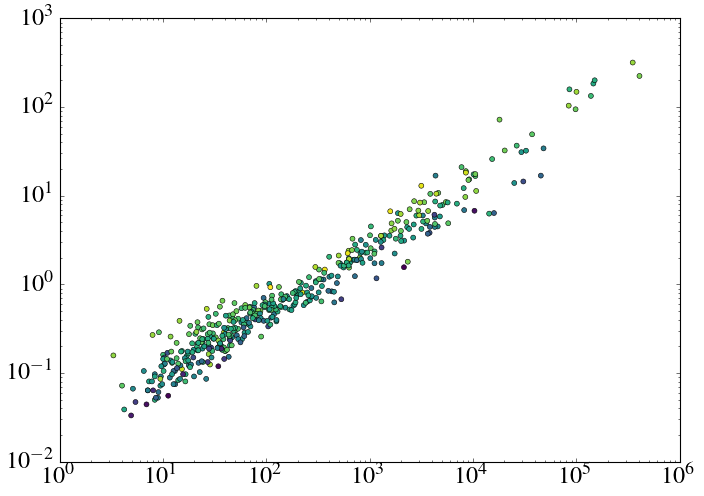

In [15]:
plt.scatter(data.Mass,data.BMRW,c=data.Temp,cmap=plt.get_cmap('viridis'))
plt.xscale('log')
plt.yscale('log')

In [16]:
RMA.RMARegression(data.logMass,data.logBMRW)

RMAResult(slope=0.72359546439967537, intercept=-1.7406845620252889, ci=0.95, slope_ci1=array([ 0.70869914,  0.73849179]), intercept_ci1=array([-1.77429816, -1.70707097]), slope_ci2=array([ 0.70885245,  0.73864511]), intercept_ci2=array([-1.77464411, -1.70741693]), RSquare=0.95117245328999933)

In [710]:
lin_model = sm.GLS(data_noTnoO.logBMRkjh,data_noTnoO[['logMass','constant']]).fit()
quad_model = sm.GLS(data_noTnoO.logBMRkjh,data_noTnoO[['constant','logMass','logMasssq']]).fit()

In [711]:
quad_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:              logBMRkjh   R-squared:                       0.961
Model:                            GLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     7706.
Date:                Thu, 17 Dec 2015   Prob (F-statistic):               0.00
Time:                        16:28:51   Log-Likelihood:                 264.88
No. Observations:                 636   AIC:                            -523.8
Df Residuals:                     633   BIC:                            -510.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
constant      -0.9515      0.032    -29.402      0.000        -1.015    -0.888
logMass        0.5400      0.026     20.736      0.000         0.489     0.591
logMasssq      0.0322      0.005      7.013      0.000         0.023     0.041
==============================================================================
Omnibus:                        5.878   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                7.917
Skew:                          -0.018   Prob(JB):                       0.0191
Kurtosis:                       3.545   Cond. No.                         61.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [703]:
quad_model.params

constant    -0.951500
logMass      0.540014
logMasssq    0.032211
dtype: float64

In [712]:
def Quad(c,M=data_noTnoO.Mass):
    return 10**(c[0] + c[1]*np.log10(M) + c[2]*np.log10(M)**2)

In [20]:
def WBE(c,M):
    return c[0]*M**(3./4.)

In [727]:
def WBE2(c,M):
    return c[0]*M**(c[1])

In [585]:
def WBEEx(c,M=data_noTnoO.Mass):
    if c[0] < 0 or c[1] < 0:
        return np.inf*np.ones(len(M))
    def f(B):
        return c[0]*B + c[1]*B**(4./3.)
    B = []
    for m in M:
        try:
            b = opt.brenth(lambda b: f(b) - m,0.0001*data.BMRkjh.min(),1000*data.BMRkjh.max())
        except ValueError:
            B.append(np.inf)
        else:
            B.append(b)
    return np.array(B)
    

In [23]:
def FH(c,M=data_noTnoO.Mass):
    res = M/(c[1]*sp.lambertw((np.exp(c[0]/c[1])*M)/c[1]))
    return np.real(res)

In [24]:
def PT(c,M=data_noTnoO.Mass):
    if c[1] < 0 or c[2] < 0 or c[0] < 0:
        return np.inf*np.ones(len(M))
    p = c[3]
    def f(B):
        return c[0]*B + c[1]*B*np.log10(B) + c[2]*(B**p)
    B = []
    for m in M:
        try:
            b = opt.brenth(lambda b: f(b) - m,0.001*data.BMRkjh.min(),1000*data.BMRkjh.max())
        except ValueError:
            B.append(np.inf)
        else:
            B.append(b)
    return np.array(B)

In [25]:
def MFBEv2(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    a0 = (3.0/dr) - (4.0/3.0)
    a1 = (3.0/(2.0*dr))
    return c0*(M**a0) + c1*(M**a1)

In [26]:
def MFBE(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    a0 = (3.0/dr) - (5.0/4.0)
    a1 = (3.0/(2*dr)) + (1.0/12.0)
    return c0*(M**a0) + c1*(M**a1)

In [146]:
def MFBEv3(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    a0 = (1.0/6.0)
    a1 = (3.0/4.0)
    return c0*(M**a0) + c1*(M**a1)

In [29]:
def MFBEv4(c,M=data_noTnoO.Mass):
    return c[0]*(M**(0.25)) + c[1]*(M**(0.75))

In [474]:
def sq_dist(c,f,X,Y,*args):
    fX = f(c,X,*args)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    return np.abs((np.log10(fX) - np.log10(Y))**2).sum()

In [475]:
def abs_dist(c,f,X,Y,*args):
    fX = f(c,X,*args)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    return np.abs((np.log10(fX) - np.log10(Y))).sum()

In [476]:
def min_dist_sq(c,f,X,Y,*args):
    fX = f(c,X,*args)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    def dist(x,x0,y0):
        return (np.log10(x)-np.log10(x0))**2 + (np.log10(f(c,x))-np.log10(y0))**2
    tot = 0.0
    for x0,y0 in zip(X,Y):
        x = opt.fmin(dist,x0=x0,args=(x0,y0),disp=False)
        tot += dist(x,x0,y0)
    return tot

In [477]:
def min_dist(c,f,X,Y,*args):
    fX = f(c,X,*args)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    def dist(x,x0,y0):
        return (np.log10(x)-np.log10(x0))**2 + (np.log10(f(c,x))-np.log10(y0))**2
    tot = 0.0
    for x0,y0 in zip(X,Y):
        x = opt.fmin(dist,x0=x0,args=(x0,y0),disp=False)
        tot += np.sqrt(dist(x,x0,y0))
    return tot

In [713]:
M = data_noTnoO.Mass.values
B = data_noTnoO.BMRkjh.values

In [716]:
cQuad = opt.fmin(sq_dist,x0=quad_model.params.values,args=(Quad,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.189606
         Iterations: 115
         Function evaluations: 202


In [717]:
cQuad_abs = opt.fmin(abs_dist,x0=quad_model.params.values,args=(Quad,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 77.406169
         Iterations: 189
         Function evaluations: 345


In [718]:
cQuad_min = opt.fmin(min_dist,x0=quad_model.params.values,args=(Quad,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 63.311617
         Iterations: 156
         Function evaluations: 278


In [719]:
cQuad_min_sq = opt.fmin(min_dist_sq,x0=quad_model.params.values,args=(Quad,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 10.835823
         Iterations: 116
         Function evaluations: 222


In [720]:
cQuad,cQuad_abs,cQuad_min,cQuad_min_sq

(array([-0.95150021,  0.54001411,  0.03221148]),
 array([-0.91975461,  0.50878382,  0.0390821 ]),
 array([-1.00416917,  0.56830103,  0.03078086]),
 array([-1.00520003,  0.57704546,  0.02731871]))

In [721]:
cWBE = opt.fmin(sq_dist,x0=[1.0],args=(WBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 18.223708
         Iterations: 19
         Function evaluations: 38


In [723]:
cWBE_abs = opt.fmin(abs_dist,x0=[1.0],args=(WBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 82.439773
         Iterations: 20
         Function evaluations: 40


In [725]:
cWBE_min = opt.fmin(min_dist,x0=cWBE_abs,args=(WBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.951819
         Iterations: 8
         Function evaluations: 16


In [726]:
cWBE_min_sq = opt.fmin(min_dist_sq,x0=cWBE,args=(WBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.663173
         Iterations: 6
         Function evaluations: 12


In [729]:
cWBE,cWBE_abs,cWBE_min,cWBE_min_sq

(array([ 0.05927734]),
 array([ 0.05839844]),
 array([ 0.05837563]),
 array([ 0.05927734]))

In [731]:
cWBE2 = opt.fmin(sq_dist,x0=[0.05,.75],args=(WBE2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 17.447646
         Iterations: 29
         Function evaluations: 57


In [732]:
cWBE2_abs = opt.fmin(abs_dist,x0=[0.05,.75],args=(WBE2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 80.838960
         Iterations: 30
         Function evaluations: 58


In [734]:
cWBE2_min = opt.fmin(min_dist,x0=cWBE2_abs,args=(WBE2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.485625
         Iterations: 27
         Function evaluations: 50


In [735]:
cWBE2_min_sq = opt.fmin(min_dist_sq,x0=cWBE2,args=(WBE2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.452219
         Iterations: 20
         Function evaluations: 40


In [736]:
cWBE2,cWBE2_abs,cWBE2_min,cWBE2_min_sq

(array([ 0.07030516,  0.71811842]),
 array([ 0.06811608,  0.71970014]),
 array([ 0.06449284,  0.73056227]),
 array([ 0.06630393,  0.72902161]))

In [737]:
cWBEEx = opt.fmin(sq_dist,x0=[100,100],args=(WBEEx,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 18.223689
         Iterations: 100
         Function evaluations: 189


In [738]:
cWBEEx_abs = opt.fmin(abs_dist,x0=cWBEEx,args=(WBEEx,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 82.439773
         Iterations: 73
         Function evaluations: 151


In [739]:
cWBEEx_min_sq = opt.fmin(min_dist_sq,x0=cWBEEx,args=(WBEEx,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.663161
         Iterations: 16
         Function evaluations: 33


In [740]:
cWBEEx_min = opt.fmin(min_dist,x0=cWBEEx_abs,args=(WBEEx,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.951819
         Iterations: 21
         Function evaluations: 52


In [742]:
cWBEEx,cWBEEx_abs,cWBEEx_min,cWBEEx_min_sq,cWBEEx

(array([  6.81709378e-10,   4.32892011e+01]),
 array([  2.05355200e-14,   4.41550143e+01]),
 array([  2.05551042e-14,   4.41397875e+01]),
 array([  6.81709378e-10,   4.32892011e+01]),
 array([  6.81709378e-10,   4.32892011e+01]))

In [743]:
cFH = opt.fmin(sq_dist,x0=[1.0,1.0],args=(FH,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 17.636520
         Iterations: 69
         Function evaluations: 135


In [744]:
cFH_abs = opt.fmin(abs_dist,x0=cFH,args=(FH,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 80.173887
         Iterations: 44
         Function evaluations: 82


In [745]:
cFH_min = opt.fmin(min_dist,x0=cFH_abs,args=(FH,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 66.692083
         Iterations: 46
         Function evaluations: 85


In [746]:
cFH_min_sq = opt.fmin(min_dist_sq,x0=cFH,args=(FH,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 12.170457
         Iterations: 36
         Function evaluations: 71


In [747]:
cFH,cFH_abs,cFH_min,cFH_min_sq

(array([ 45.4163532 ,  30.06460515]),
 array([ 44.40156848,  29.81634838]),
 array([ 45.27599382,  27.19337276]),
 array([ 46.79208493,  26.67444916]))

In [748]:
cPT = opt.fmin(sq_dist,x0=[1.0,0.0,1.0,4./3.],args=(PT,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 17.450197
         Iterations: 320
         Function evaluations: 558


In [749]:
cPT_abs = opt.fmin(abs_dist,x0=cPT,args=(PT,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 80.844911
         Iterations: 148
         Function evaluations: 254


In [750]:
cPT_min = opt.fmin(min_dist,x0=cPT_abs,args=(PT,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.488709
         Iterations: 79
         Function evaluations: 142


In [751]:
cPT_min_sq = opt.fmin(min_dist_sq,x0=cPT,args=(PT,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.452815
         Iterations: 249
         Function evaluations: 443


In [752]:
cPT,cPT_abs,cPT_min,cPT_min_sq

(array([  4.34948278e-02,   3.33509723e-11,   4.02789034e+01,
          1.39283759e+00]),
 array([  3.82966014e-02,   2.85425517e-11,   4.16903156e+01,
          1.38988602e+00]),
 array([  3.91141665e-02,   2.98778499e-11,   4.25825808e+01,
          1.36892039e+00]),
 array([  2.17105994e-02,   2.05058061e-17,   4.13095555e+01,
          1.37203877e+00]))

In [753]:
cMFBE = opt.fmin(sq_dist,x0=[1.0,1.0,2.0],args=(MFBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.750858
         Iterations: 121
         Function evaluations: 222


In [754]:
cMFBE_abs = opt.fmin(abs_dist,x0=cMFBE,args=(MFBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 79.028794
         Iterations: 74
         Function evaluations: 132


In [755]:
cMFBE_min = opt.fmin(min_dist,x0=cMFBE_abs,args=(MFBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.189255
         Iterations: 89
         Function evaluations: 161


In [756]:
cMFBE_min_sq = opt.fmin(min_dist_sq,x0=cMFBE,args=(MFBE,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.336367
         Iterations: 64
         Function evaluations: 119


In [757]:
cMFBE,cMFBE_abs,cMFBE_min,cMFBE_min_sq

(array([ 0.11408031,  0.04548792,  2.18448717]),
 array([ 0.14641619,  0.03036833,  2.03598797]),
 array([ 0.07772   ,  0.04780617,  2.18349368]),
 array([ 0.05849101,  0.054449  ,  2.2403316 ]))

In [758]:
cMFBEv2 = opt.fmin(sq_dist,x0=[1.0,1.0,2.0],args=(MFBEv2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.610423
         Iterations: 118
         Function evaluations: 211


In [759]:
cMFBEv2_abs = opt.fmin(abs_dist,x0=cMFBEv2,args=(MFBEv2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 77.177088
         Iterations: 81
         Function evaluations: 147


In [760]:
cMFBEv2_min = opt.fmin(min_dist,x0=cMFBEv2_abs,args=(MFBEv2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 62.926610
         Iterations: 78
         Function evaluations: 134


In [761]:
cMFBEv2_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv2,args=(MFBEv2,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.274379
         Iterations: 67
         Function evaluations: 122


In [762]:
cMFBEv2, cMFBEv2_abs, cMFBEv2_min, cMFBEv2_min_sq

(array([ 0.11625917,  0.03391259,  1.8732232 ]),
 array([ 0.09704566,  0.0054881 ,  1.57314221]),
 array([ 0.08440747,  0.00395266,  1.53713788]),
 array([ 0.06853697,  0.04774662,  1.95447985]))

In [763]:
cMFBEv3 = opt.fmin(sq_dist,x0=[1.0,1.0,3.0],args=(MFBEv3,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.766828
         Iterations: 83
         Function evaluations: 152


In [764]:
cMFBEv3_abs = opt.fmin(abs_dist,x0=cMFBEv3,args=(MFBEv3,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 79.216367
         Iterations: 64
         Function evaluations: 118


In [765]:
cMFBEv3_min = opt.fmin(min_dist,x0=cMFBEv3_abs,args=(MFBEv3,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.058064
         Iterations: 71
         Function evaluations: 129


In [766]:
cMFBEv3_min_sq = opt.fmin(min_dist,x0=cMFBEv3,args=(MFBEv3,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.058064
         Iterations: 71
         Function evaluations: 135


In [767]:
cMFBEv3,cMFBEv3_abs,cMFBEv3_min,cMFBEv3_min_sq

(array([ 0.0773451 ,  0.05261677,  4.28944084]),
 array([ 0.08273963,  0.05154788,  4.1710581 ]),
 array([ 0.04281694,  0.05502559,  4.14943809]),
 array([ 0.04281688,  0.05502563,  3.26361697]))

In [768]:
cMFBEv4 = opt.fmin(sq_dist,x0=[1.0,1.0],args=(MFBEv4,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.752171
         Iterations: 52
         Function evaluations: 101


In [769]:
cMFBEv4_abs = opt.fmin(abs_dist,x0=[1.0,1.0],args=(MFBEv4,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 79.119868
         Iterations: 53
         Function evaluations: 101


In [770]:
cMFBEv4_min = opt.fmin(min_dist,x0=cMFBEv4_abs,args=(MFBEv4,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 64.937757
         Iterations: 25
         Function evaluations: 47


In [771]:
cMFBEv4_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv4,args=(MFBEv4,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.262224
         Iterations: 23
         Function evaluations: 45


In [772]:
cMFBEv4,cMFBEv4_abs,cMFBEv4_min,cMFBEv4_min_sq

(array([ 0.06501198,  0.05180199]),
 array([ 0.06693844,  0.05079918]),
 array([ 0.04270806,  0.05363637]),
 array([ 0.04304239,  0.05426722]))

In [773]:
def MFBEv5(c,M=data_noTnoO.Mass):
    c0 = c[0]
    #a0 = c[1]
    c1 = c[1]
    a1 = c[2]
    #if np.random.random() < 0.5:
    return c0*M+c1*M**(a1)

In [774]:
cMFBEv5 = opt.fmin(sq_dist,x0=[0.01,0.01,0.6],args=(MFBEv5,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.091072
         Iterations: 106
         Function evaluations: 187


In [775]:
cMFBEv5_abs = opt.fmin(abs_dist,x0=cMFBEv5,args=(MFBEv5,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 77.033857
         Iterations: 50
         Function evaluations: 94


In [776]:
cMFBEv5_min = opt.fmin(min_dist,x0=cMFBEv5_abs,args=(MFBEv5,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 62.814009
         Iterations: 66
         Function evaluations: 118


In [777]:
cMFBEv5_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv5,args=(MFBEv5,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 10.691945
         Iterations: 40
         Function evaluations: 73


In [778]:
cMFBEv5,cMFBEv5_abs,cMFBEv5_min,cMFBEv5_min_sq

(array([ 0.0026493 ,  0.09571823,  0.60662923]),
 array([ 0.00326676,  0.09881824,  0.58796207]),
 array([ 0.00308685,  0.08815905,  0.61559155]),
 array([ 0.00256967,  0.08749987,  0.62706833]))

In [779]:
def MFBEv6(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    c2 = c[2]
    dr = c[3]
    m = c[4]
    if c0 <0 or c1<0 or c2<0 or dr>3:# or dr<2 or m>1:
        return np.inf*np.ones(len(M))
    #c2 = c[2]
    #if np.random.random() < 0.5:
    return c0*M**(m/3.0) + c1*M**(m*((4.0/dr) - (5.0/3.0))) + c2*M**(m*(2./dr))

In [780]:
cMFBEv6_abs = opt.fmin(abs_dist,x0=[0.1,0.1,0.1,2.0,0.75],args=(MFBEv6,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 79.357170
         Iterations: 149
         Function evaluations: 258


In [781]:
cMFBEv6 = opt.fmin(sq_dist,x0=cMFBEv6_abs,args=(MFBEv6,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.389366
         Iterations: 190
         Function evaluations: 320


In [782]:
cMFBEv6_min = opt.fmin(min_dist,x0=cMFBEv6_abs,args=(MFBEv6,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 64.285615
         Iterations: 251
         Function evaluations: 420


In [783]:
cMFBEv6_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv6,args=(MFBEv6,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.075894
         Iterations: 163
         Function evaluations: 272


In [784]:
cMFBEv6,cMFBEv6_abs,cMFBEv6_min,cMFBEv6_min_sq

(array([  1.03117471e-01,   1.68050010e-07,   2.50285153e-02,
          2.91177025e+00,   1.20245563e+00]),
 array([ 0.04185366,  0.10939236,  0.04645843,  2.99988684,  1.14205586]),
 array([  8.49309250e-02,   2.15648504e-07,   3.04514095e-02,
          2.76674358e+00,   1.12850143e+00]),
 array([  8.00397922e-02,   1.65118635e-07,   3.07848465e-02,
          2.99999980e+00,   1.21325617e+00]))

In [785]:
def MFBEv8(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    #a1 = c[2]
    #if c0 < 0 or c1 < 0 or a1 < 0 or a1 > 2.0:
    #    return np.inf*np.ones(len(M))
    return c0*M + c1*M**(0.75)

In [787]:
cMFBEv8 = opt.fmin(sq_dist,x0=[0.05,0.05],args=(MFBEv8,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 18.084772
         Iterations: 49
         Function evaluations: 94


In [788]:
cMFBEv8_abs = opt.fmin(abs_dist,x0=cMFBEv8,args=(MFBEv8,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 82.261243
         Iterations: 18
         Function evaluations: 33


In [789]:
cMFBEv8_min = opt.fmin(min_dist,x0=cMFBEv8_abs,args=(MFBEv8,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.945488
         Iterations: 29
         Function evaluations: 55


In [790]:
cMFBEv8_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv8,args=(MFBEv8,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.654618
         Iterations: 20
         Function evaluations: 38


In [791]:
def MFBEv9(c,M=data_noTnoO.Mass,disp=False):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    
    a0 = ((6.0/dr) - (8.0/3.0))/((2.0/dr) + (1./3.))
    a1 = ((8.0/(3.0*dr)) - (2.0/9))/((2.0/dr) + (1./3.))
    if c0 < 0 or c1 < 0:
        return np.inf*np.ones(len(M))
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    if disp:
        print a0,a1
    return c0*M**a0 + c1*M**a1

In [792]:
cMFBEv9 = opt.fmin(sq_dist,x0=[0.05,0.05,2.5],args=(MFBEv9,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 17.025299
         Iterations: 81
         Function evaluations: 151


In [793]:
cMFBEv9_abs = opt.fmin(abs_dist,x0=cMFBEv9,args=(MFBEv9,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 80.022724
         Iterations: 60
         Function evaluations: 104


In [794]:
cMFBEv9_min = opt.fmin(min_dist,x0=cMFBEv9,args=(MFBEv9,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 65.424952
         Iterations: 74
         Function evaluations: 138


In [795]:
cMFBEv9_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv9,args=(MFBEv9,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.435440
         Iterations: 50
         Function evaluations: 96


In [796]:
cMFBEv9,cMFBEv9_abs,cMFBEv9_min,cMFBEv9_min_sq

(array([ 0.14581453,  0.05694285,  2.4973434 ]),
 array([ 0.13900314,  0.05966589,  2.54914163]),
 array([ 0.03498068,  0.06309629,  2.5744289 ]),
 array([ 0.03590536,  0.06337076,  2.56109614]))

In [797]:
def MFBEv10(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    
    a0 = ((7.0/3.0) - dr)
    a1 = (1.0 - (dr/9.0))
    if c0 < 0 or c1 < 0:
        return np.inf*np.ones(len(M))
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    return c0*M**a0 + c1*M**a1

In [798]:
cMFBEv10 = opt.fmin(sq_dist,x0=[0.05,0.05,2.5],args=(MFBEv10,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 16.479433
         Iterations: 84
         Function evaluations: 150


In [799]:
cMFBEv10_abs = opt.fmin(abs_dist,x0=cMFBEv10,args=(MFBEv10,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 78.509079
         Iterations: 61
         Function evaluations: 111


In [800]:
cMFBEv10_min = opt.fmin(min_dist,x0=cMFBEv10_abs,args=(MFBEv10,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 64.196624
         Iterations: 72
         Function evaluations: 129


In [801]:
cMFBEv10_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv10,args=(MFBEv10,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.024669
         Iterations: 56
         Function evaluations: 101


In [802]:
cMFBEv10,cMFBEv10_abs,cMFBEv10_min,cMFBEv10_min_sq

(array([ 0.07223946,  0.03357416,  1.88937698]),
 array([ 0.06968625,  0.03145085,  1.86344434]),
 array([ 0.05657061,  0.03009046,  1.80909427]),
 array([ 0.05860025,  0.03005519,  1.80891591]))

In [835]:
def MFBEv11(c,M=data_noTnoO.Mass,disp=False):
    c0 = c[0]
    c1 = c[1]
    dr = 24.0/11.0
    
    a0 = ((6.0/dr) - (8.0/3.0))/((2.0/dr) + (1./3.))
    a1 = ((8.0/(3.0*dr)) - (2.0/9))/((2.0/dr) + (1./3.))
    if c0 < 0 or c1 < 0:
        return np.inf*np.ones(len(M))
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    if disp:
        print a0,a1
    return c0*M**a0 + c1*M**a1

In [836]:
cMFBEv11 = opt.fmin(sq_dist,x0=[0.05,0.05,2.5],args=(MFBEv11,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 17.213650
         Iterations: 77
         Function evaluations: 142


In [837]:
cMFBEv11_abs = opt.fmin(abs_dist,x0=cMFBEv11,args=(MFBEv11,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 79.781873
         Iterations: 104
         Function evaluations: 181


In [840]:
cMFBEv11_min = opt.fmin(min_dist,x0=cMFBEv11_abs,args=(MFBEv11,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 66.113277
         Iterations: 44
         Function evaluations: 83


In [841]:
cMFBEv11_min_sq = opt.fmin(min_dist_sq,x0=cMFBEv11,args=(MFBEv11,M,B),xtol=10**-4,ftol=10**-4)

Optimization terminated successfully.
         Current function value: 11.806593
         Iterations: 60
         Function evaluations: 110


In [852]:
cMFBEv11,cMFBEv11_abs,cMFBEv11_min,cMFBEv11_min_sq

(array([ 0.17538683,  0.03668208,  2.42929733]),
 array([ 0.18505367,  0.03711717,  0.19433727]),
 array([ 0.14551851,  0.03870019,  0.21465088]),
 array([ 0.13151142,  0.03871785,  2.7835217 ]))

In [557]:
a0s = np.arange(0.0,1.201,0.001)
fopts = []
rets = []
i = 0
for a0 in a0s:
    if i==0:
        x0=[.1,.1,.5]
    else:
        x0= ret[0]
    ret = opt.fmin(sq_dist,x0=x0,args=(MFBEv7,data_noTnoO.Mass,data_noTnoO.BMRkjh,a0),maxiter=100000,xtol=10**-12,ftol=10**-12,disp=False,full_output=True)
    rets.append(ret)
    fopts.append(ret[1])
    if i % 20 == 0:
        print(fopts[-1],a0,ret[0][2],ret[0][:2])
    i+=1

(16.857956885598011, 0.0, 0.75283688565029228, array([ 0.11202763,  0.05282081]))
(16.766202498606113, 0.10000000000000001, 0.76133877949512485, array([ 0.10609003,  0.04882192]))
(16.657355727902072, 0.20000000000000001, 0.77332267932485488, array([ 0.10187221,  0.04348154]))
(16.530788522515653, 0.29999999999999999, 0.79111932776734117, array([ 0.09962833,  0.03624958]))
(16.38773482116348, 0.40000000000000002, 0.81977539073608219, array([ 0.09960041,  0.02646473]))
(16.232913912582138, 0.5, 0.87262364640253232, array([ 0.10098755,  0.01407542]))
(16.094482305339554, 0.59999999999999998, 0.99671941265566888, array([ 0.09743656,  0.00284468]))
(16.497448524036518, 0.70000000000000007, 1.3958752598651993, array([  7.45861620e-02,   1.24911644e-05]))
(16.41616056362815, 0.80000000000000004, 0.4227742977781262, array([ 0.03113002,  0.08223672]))
(16.167031252531437, 0.90000000000000002, 0.55313262850660561, array([ 0.0094017 ,  0.09560509]))
(16.091072085467101, 1.0, 0.60664034049546622,

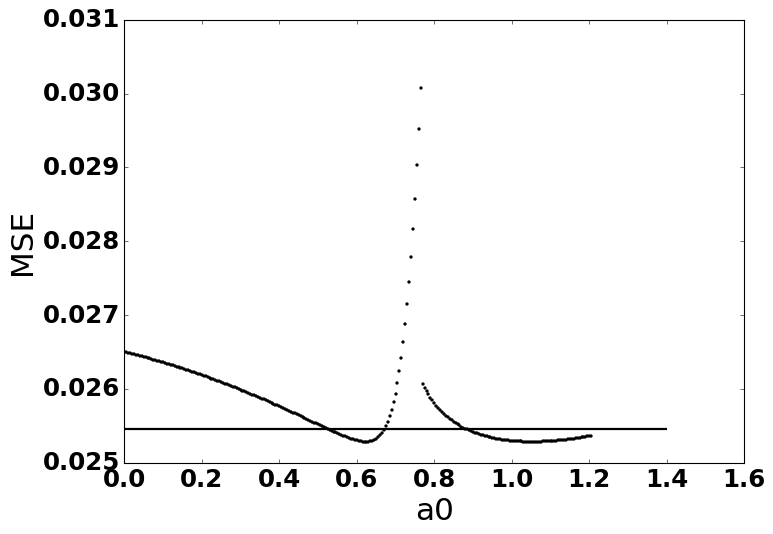

In [559]:
fopts = np.array(fopts)
fopts_norm = (fopts-fopts.min())/(fopts.max()-fopts.min()) + .1
MSE = fopts/len(data_noTnoO.Mass)
#plt.scatter(a0s,[ret[0][2] for ret in rets],s=(5*fopts_norm)**2,c='k')
#plt.ylabel('a1')
#plt.ylim(0,1)
plt.plot(a0s,MSE,'k.')
plt.hlines(0.025455355905786726,*plt.xlim())
plt.ylabel('MSE')
plt.xlabel('a0')


In [560]:
sorted(zip(a0s,fopts),key=lambda i:i[1])[:10]

[(1.05, 16.083143874319337),
 (1.0549999999999999, 16.083164496881743),
 (0.625, 16.083196524189919),
 (1.0449999999999999, 16.083260817998923),
 (1.0600000000000001, 16.083319610447528),
 (0.62, 16.083442115967134),
 (1.04, 16.083518511009615),
 (1.0649999999999999, 16.083606239914374),
 (1.0349999999999999, 16.083920252732348),
 (1.0700000000000001, 16.084021503264051)]

In [394]:
sBMR = np.logspace(np.log10(0.07),np.log10(2000),1000,base=10)
sMass = np.logspace(0,6,1000,base=10)

In [821]:
cMFBEv9_min_sq

array([ 0.03590536,  0.06337076,  2.56109614])

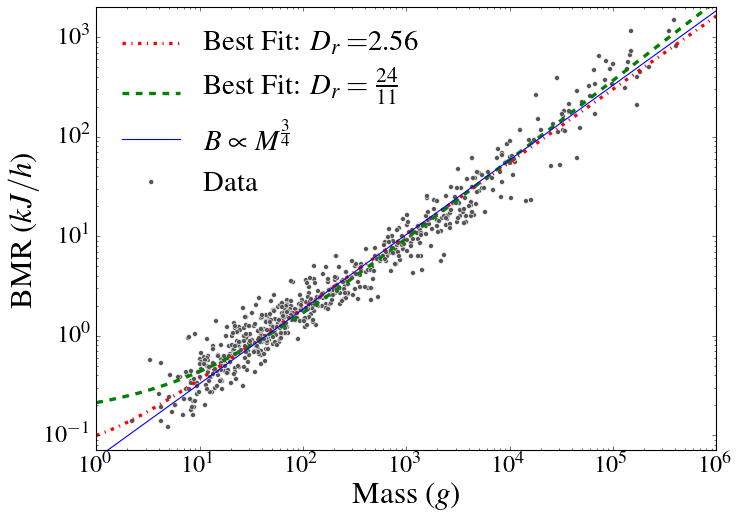

In [863]:
#plt.figure(figsize=(10,10))
mod_label = 'Best Fit: $D_r=$%1.2f'%cMFBEv9_min_sq[2]
plt.scatter(data_noTnoO.Mass,data_noTnoO.BMRkjh,c='#555555',marker='o',edgecolor='w',label='Data')
plt.loglog(sMass,MFBEv9(cMFBEv9_min_sq,sMass),'r-.',lw=3,label=mod_label)
#plt.loglog(sMass,MFBEv10(cMFBEv10_min,sMass),'g-',lw=1,label='Best Fit: $D_r=2.24$')
plt.loglog(sMass,MFBEv11(cMFBEv11,sMass),'g--',lw=3,label='Best Fit: $D_r=\\frac{24}{11}$')

plt.loglog(sMass,WBE(cWBE_min,sMass),'b-',lw=1,label='$B \propto M^{\\frac{3}{4}}$')
#plt.loglog(sMass,MFBEv10(cMFBEv10_min_sq,sMass),'g--',lw=1,label='Best fit v9')
plt.xlim(1,10**6)
plt.ylim(0.07,2000)
plt.xlabel('Mass ($g$)')
plt.ylabel('BMR ($kJ/h$)')
plt.legend(loc='upper left',frameon=False)
#plt.yscale('symlog',linthreshy=.1)
#plt.savefig('../Figures/OrganismsPowerScaling.pdf',dpi=600)
plt.savefig('../Figures/OrganismsPowerScalingv2.pdf',dpi=600)

In [825]:
mod_label

'Best Fit: $D_r=2.56$'

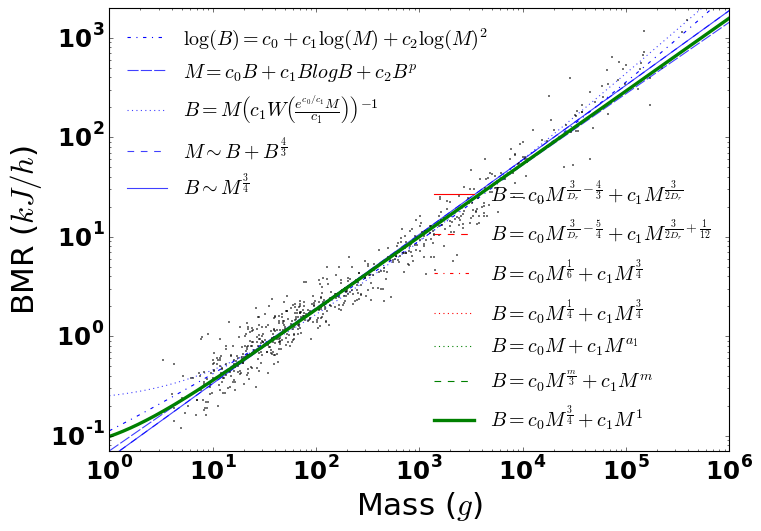

In [660]:
a0 = .75
bh1, = plt.loglog(sMass,10**quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(sMass))]),'b-.',lw=1,label='$\\log(B) = c_0 + c_1\\log(M) + c_2\\log(M)^2$')
bh2, = plt.loglog(sMass,PT(cPT,sMass),color='b',linestyle=(0,(10,2)),lw=1,label='$M = c_0 B + c_1 B log B + c_2 B^p$',alpha=a0)
bh3, = plt.loglog(sMass,FH(cFH,sMass),'b:',lw=1,label='$B = M \\left( c_1 W \\left( \\frac{e^{c_0/c_1} M}{c_1} \\right)\\right)^{-1}$',alpha=a0)
bh4, = plt.loglog(sMass,WBEEx(cWBEEx,sMass),color='b',ls='--',lw=1,label='$M \sim B + B^{\\frac{4}{3}}$',alpha=a0)
bh5, = plt.loglog(sMass,WBE(cWBE,sMass),color = 'b',ls='-',lw=1,label='$B \sim M^{\\frac{3}{4}}$',alpha=a0)
dh, = plt.plot(data_noTnoO.Mass,data_noTnoO.BMRkjh,'k.',label='Data',ms=3)


#rh1, = plt.loglog(sMass,MFBE(cMFBE,sMass),'r--',lw=1,label='$B =c_0 M^{\\frac{3}{D_r} - \\frac{5}{4}} + c_1M^{\\frac{3}{2D_r} + \\frac{1}{12}}$')
#rh2, = plt.loglog(sMass,MFBEv2(cMFBEv2,sMass),'r-',lw=1,label='$B =c_0 M^{\\frac{3}{D_r} - \\frac{4}{3}} + c_1M^{\\frac{3}{2D_r}}$')
#rh3, = plt.loglog(sMass,MFBEv3(cMFBEv3,sMass),'r-.',lw=1,label='$B =c_0 M^{\\frac{1}{6}} + c_1M^{\\frac{3}{4}}$')
#rh4, = plt.loglog(sMass,MFBEv4(cMFBEv4,sMass),'r:',lw=1,label='$B =c_0 M^{\\frac{1}{4}} + c_1M^{\\frac{3}{4}}$')
#rh5, = plt.loglog(sMass,MFBEv5(cMFBEv5,sMass),'g:',lw=1,label='$B =c_0 M + c_1M^{a_1}$')
#rh6, = plt.loglog(sMass,MFBEv6(cMFBEv6,sMass),'g--',lw=1,label='$B =c_0 M^{\\frac{m}{3}} + c_1M^{m}$')
#rh7, = plt.loglog(sMass,MFBEv7(cMFBEv7,sMass,0.75),'g-',lw=3,label='$B =c_0 M^{\\frac{3}{4}} + c_1M^{1}$')
#rh7, = plt.loglog(sMass,MFBEv8(cMFBEv8,sMass),'g-',lw=3,label='$B =c_0 M^{\\frac{3}{4}} + c_1M^{1}$')
rh9, = plt.loglog(sMass,MFBEv9(cMFBEv9_min,sMass),'g-',lw=3,label='New MODEL!!')


plt.xlim(1,10**6)
plt.ylim(0.07,2000)
plt.xlabel('Mass ($g$)')
plt.ylabel('BMR ($kJ/h$)')
first_legend = plt.legend(handles=[bh1,bh2,bh3,bh4,bh5],loc='upper left',fontsize=18,ncol=1,frameon=False)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[rh2,rh1,rh3,rh4,rh5,rh6,rh7],loc='lower right',fontsize=18,ncol=1,frameon=False)

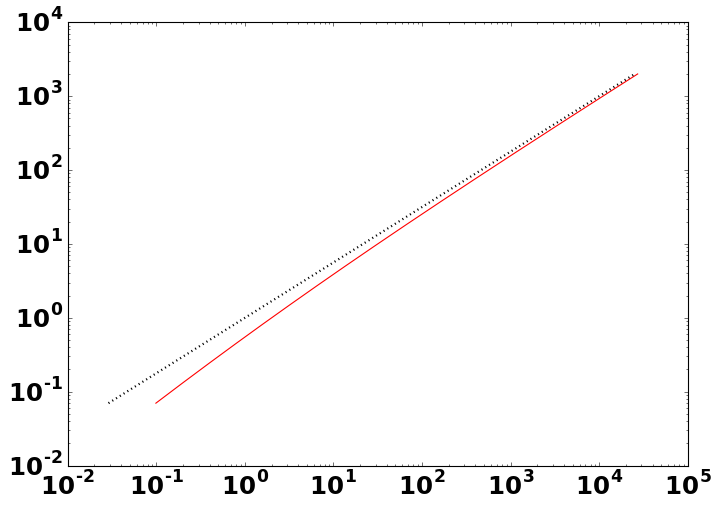

In [598]:
plt.loglog(sBMR**(4./3.) + sBMR,sBMR,'r-',lw=1)
plt.loglog(sBMR**(4./3.),sBMR,'k:')

In [599]:
cMFBE

array([ 0.11407942,  0.04548941,  2.18449392])

In [842]:
M = data_noTnoO.Mass
B = data_noTnoO.BMRkjh
dist_func = sq_dist
d = {'Quad':dist_func(cQuad,Quad,M,B)/len(M),
 'PT':dist_func(cPT,PT,M,B)/len(M),
 'FH':dist_func(cFH,FH,M,B)/len(M),
 'WBEEx':dist_func(cWBEEx,WBEEx,M,B)/len(M),
 'WBE':dist_func(cWBE,WBE,M,B)/len(M),
 'WBE2':dist_func(cWBE2,WBE2,M,B)/len(M),
 'MFBEv1 (Paper)':dist_func(cMFBE,MFBE,M,B)/len(M),
 'MFBEv2':dist_func(cMFBEv2,MFBEv2,M,B)/len(M),
 'MFBEv3':dist_func(cMFBEv3,MFBEv3,M,B)/len(M),
 'MFBEv4':dist_func(cMFBEv4,MFBEv4,M,B)/len(M),
 'MFBEv5':dist_func(cMFBEv5,MFBEv5,M,B)/len(M),
 'MFBEv6':dist_func(cMFBEv6,MFBEv6,M,B)/len(M),
 'MFBEv8':dist_func(cMFBEv8,MFBEv8,M,B)/len(M),
 'MFBEv9':dist_func(cMFBEv9,MFBEv9,M,B)/len(M),
 'MFBEv10':dist_func(cMFBEv10,MFBEv10,M,B)/len(M),
 'MFBEv11':dist_func(cMFBEv11,MFBEv11,M,B)/len(M)}
sorted(d.items(),key=lambda i: i[1])

[('MFBEv5', 0.02530042831515646),
 ('Quad', 0.025455355905786715),
 ('MFBEv6', 0.025769443192342176),
 ('MFBEv10', 0.025911058522863347),
 ('MFBEv2', 0.026117017236119488),
 ('MFBEv1 (Paper)', 0.026337827252397788),
 ('MFBEv4', 0.026339892054528247),
 ('MFBEv3', 0.026362936877494535),
 ('MFBEv9', 0.026769338619693973),
 ('MFBEv11', 0.027065487896588615),
 ('WBE2', 0.027433406025689496),
 ('PT', 0.02743741632224198),
 ('FH', 0.027730377186440072),
 ('MFBEv8', 0.02843517532874008),
 ('WBEEx', 0.028653599343497777),
 ('WBE', 0.028653629370625787)]

In [843]:
M = data_noTnoO.Mass
B = data_noTnoO.BMRkjh
dist_func = abs_dist
d = {'Quad':dist_func(cQuad_abs,Quad,M,B)/len(M),
 'PT':dist_func(cPT_abs,PT,M,B)/len(M),
 'FH':dist_func(cFH_abs,FH,M,B)/len(M),
 'WBEEx':dist_func(cWBEEx_abs,WBEEx,M,B)/len(M),
 'WBE':dist_func(cWBE_abs,WBE,M,B)/len(M),
 'WBE2':dist_func(cWBE2_abs,WBE2,M,B)/len(M),
 'MFBEv1 (Paper)':dist_func(cMFBE_abs,MFBE,M,B)/len(M),
 'MFBEv2':dist_func(cMFBEv2_abs,MFBEv2,M,B)/len(M),
 'MFBEv3':dist_func(cMFBEv3_abs,MFBEv3,M,B)/len(M),
 'MFBEv4':dist_func(cMFBEv4_abs,MFBEv4,M,B)/len(M),
 'MFBEv5':dist_func(cMFBEv5_abs,MFBEv5,M,B)/len(M),
 'MFBEv6':dist_func(cMFBEv6_abs,MFBEv6,M,B)/len(M),
 'MFBEv8':dist_func(cMFBEv8_abs,MFBEv8,M,B)/len(M),
 'MFBEv9':dist_func(cMFBEv9_abs,MFBEv9,M,B)/len(M),
 'MFBEv10':dist_func(cMFBEv10_abs,MFBEv10,M,B)/len(M),
 'MFBEv11':dist_func(cMFBEv11_abs,MFBEv11,M,B)/len(M)}
sorted(d.items(),key=lambda i: i[1])

[('MFBEv5', 0.12112241624747824),
 ('MFBEv2', 0.12134762209063042),
 ('Quad', 0.12170781286778609),
 ('MFBEv10', 0.12344194832538559),
 ('MFBEv1 (Paper)', 0.12425911076877769),
 ('MFBEv4', 0.1244023083187253),
 ('MFBEv3', 0.12455403650131638),
 ('MFBEv6', 0.12477542492325787),
 ('MFBEv11', 0.1254431967893861),
 ('MFBEv9', 0.12582189376918135),
 ('FH', 0.1260595702589926),
 ('WBE2', 0.12710528251882836),
 ('PT', 0.12711463949094645),
 ('MFBEv8', 0.12934157648654204),
 ('WBE', 0.12962228506433632),
 ('WBEEx', 0.12962228506435042)]

In [844]:
M = data_noTnoO.Mass
B = data_noTnoO.BMRkjh
dist_func = min_dist
d = {'Quad':dist_func(cQuad_min,Quad,M,B)/len(M),
 'PT':dist_func(cPT_min,PT,M,B)/len(M),
 'FH':dist_func(cFH_min,FH,M,B)/len(M),
 'WBEEx':dist_func(cWBEEx_min,WBEEx,M,B)/len(M),
 'WBE':dist_func(cWBE_min,WBE,M,B)/len(M),
 'WBE2':dist_func(cWBE2_min,WBE2,M,B)/len(M),
 'MFBEv1 (Paper)':dist_func(cMFBE_min,MFBE,M,B)/len(M),
 'MFBEv2':dist_func(cMFBEv2_min,MFBEv2,M,B)/len(M),
 'MFBEv3':dist_func(cMFBEv3_min,MFBEv3,M,B)/len(M),
 'MFBEv4':dist_func(cMFBEv4_min,MFBEv4,M,B)/len(M),
 'MFBEv5':dist_func(cMFBEv5_min,MFBEv5,M,B)/len(M),
 'MFBEv6':dist_func(cMFBEv6_min,MFBEv6,M,B)/len(M),
 'MFBEv8':dist_func(cMFBEv8_min,MFBEv8,M,B)/len(M),
 'MFBEv9':dist_func(cMFBEv9_min,MFBEv9,M,B)/len(M),
 'MFBEv10':dist_func(cMFBEv10_min,MFBEv10,M,B)/len(M),
 'MFBEv11':dist_func(cMFBEv11_min,MFBEv11,M,B)/len(M)}
sorted(d.items(),key=lambda i: i[1])

[('MFBEv5', array([ 0.09876416])),
 ('MFBEv2', array([ 0.09894121])),
 ('Quad', array([ 0.09954657])),
 ('MFBEv10', array([ 0.10093809])),
 ('MFBEv6', array([ 0.10107801])),
 ('MFBEv4', array([ 0.10210339])),
 ('MFBEv3', array([ 0.10229255])),
 ('MFBEv1 (Paper)', array([ 0.10249883])),
 ('MFBEv9', array([ 0.10286942])),
 ('WBE2', array([ 0.10296482])),
 ('PT', array([ 0.10296967])),
 ('MFBEv8', array([ 0.10368787])),
 ('WBEEx', array([ 0.10369783])),
 ('WBE', array([ 0.10369783])),
 ('MFBEv11', array([ 0.10395169])),
 ('FH', array([ 0.10486177]))]

In [845]:
M = data_noTnoO.Mass
B = data_noTnoO.BMRkjh
dist_func = min_dist_sq
d = {'Quad':dist_func(cQuad_min_sq,Quad,M,B)/len(M),
 'PT':dist_func(cPT_min_sq,PT,M,B)/len(M),
 'FH':dist_func(cFH_min_sq,FH,M,B)/len(M),
 'WBEEx':dist_func(cWBEEx_min_sq,WBEEx,M,B)/len(M),
 'WBE':dist_func(cWBE_min_sq,WBE,M,B)/len(M),
 'WBE2':dist_func(cWBE2_min_sq,WBE2,M,B)/len(M),
 'MFBEv1 (Paper)':dist_func(cMFBE_min_sq,MFBE,M,B)/len(M),
 'MFBEv2':dist_func(cMFBEv2_min_sq,MFBEv2,M,B)/len(M),
 'MFBEv3':dist_func(cMFBEv3_min_sq,MFBEv3,M,B)/len(M),
 'MFBEv4':dist_func(cMFBEv4_min_sq,MFBEv4,M,B)/len(M),
 'MFBEv5':dist_func(cMFBEv5_min_sq,MFBEv5,M,B)/len(M),
 'MFBEv6':dist_func(cMFBEv6_min_sq,MFBEv6,M,B)/len(M),
 'MFBEv8':dist_func(cMFBEv8_min_sq,MFBEv8,M,B)/len(M),
 'MFBEv9':dist_func(cMFBEv9_min_sq,MFBEv9,M,B)/len(M),
 'MFBEv10':dist_func(cMFBEv10_min_sq,MFBEv10,M,B)/len(M),
 'MFBEv11':dist_func(cMFBEv11_min_sq,MFBEv11,M,B)/len(M)}
sorted(d.items(),key=lambda i: i[1])

[('MFBEv5', array([ 0.01681123])),
 ('Quad', array([ 0.01703746])),
 ('MFBEv10', array([ 0.01733438])),
 ('MFBEv6', array([ 0.01741493])),
 ('MFBEv4', array([ 0.0177079])),
 ('MFBEv2', array([ 0.01772701])),
 ('MFBEv3', array([ 0.01777814])),
 ('MFBEv1 (Paper)', array([ 0.01782448])),
 ('MFBEv9', array([ 0.01798025])),
 ('WBE2', array([ 0.01800663])),
 ('PT', array([ 0.01800757])),
 ('MFBEv8', array([ 0.01832487])),
 ('WBEEx', array([ 0.0183383])),
 ('WBE', array([ 0.01833832])),
 ('MFBEv11', array([ 0.01856383])),
 ('FH', array([ 0.01913594]))]

In [ ]:
plt.scatter(data_noTnoO.Mass,data_noTnoO.BMRkjh,c='k',marker='o',edgecolor='w',label='Data')
plt.loglog(sMass,WBEEx(cWBEEx_min,sMass),'c-',lw=1,label='WBE')
plt.loglog(sMass,FH(cFH_min,sMass),'m-',lw=1,label='FH')
plt.loglog(sMass,10**quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(sMass))]),'b-',lw=1,label='Quad')
plt.loglog(sMass,PT(cPT_min,sMass),'g-',lw=1,label='PT')
plt.loglog(sMass,MFBE(cMFBE_min,sMass),'r--',lw=3,label='MFBE')
plt.xlim(1,10**6)
plt.ylim(0.07,2000)
plt.xlabel('Mass ($g$)')
plt.ylabel('BMR ($kJ/h$)')
plt.legend(loc='lower right',fontsize=22,ncol=2)

In [ ]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_min,sMass))
resid_FH = sBMR - np.log10(FH(cFH_min,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_min,sMass))
resid_PT = sBMR - np.log10(PT(cPT_min,sMass))
#plt.semilogx(sMass,resid_MFBE,'k.',label='MFBE Residuals')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

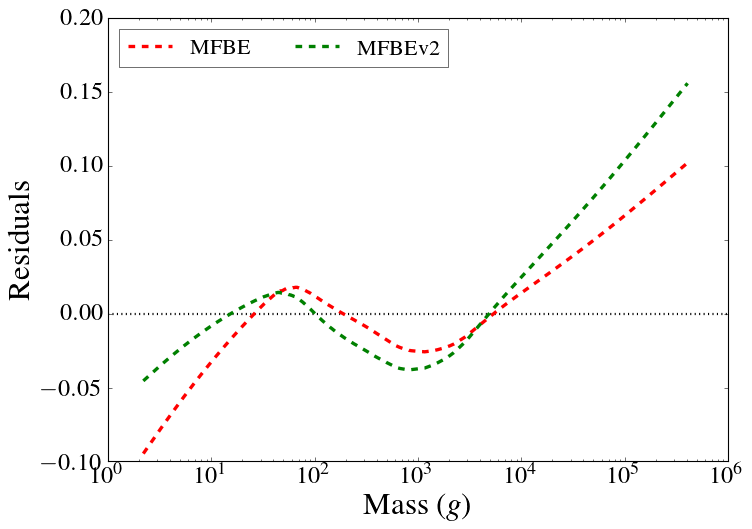

In [49]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
#resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
#resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_min,sMass))
#resid_FH = sBMR - np.log10(FH(cFH_min,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE,sMass))
resid_MFBEv2 = sBMR - np.log10(MFBEv2(cMFBEv2_min,sMass))
#resid_PT = sBMR - np.log10(PT(cPT_min,sMass))
#plt.semilogx(sMass,resid_MFBE,'k.',label='MFBE Residuals')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBEv2,np.log10(sMass),return_sorted=False),'g--',lw=3,label='MFBEv2')
#plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
#plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
#plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
#plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [50]:
print((resid_MFBE**2).sum())
print((resid_MFBEv2**2).sum())

16.7508581058
17.1107056133


In [ ]:
cMFBE_min

In [ ]:
cMFBE_abs

In [ ]:
cMFBE

In [ ]:
print((resid_MFBE**2).sum())
print((resid_quad**2).sum())
print((resid_FH**2).sum())
print((resid_PT**2).sum())
print((resid_WBEEx**2).sum())

In [ ]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_abs,sMass))
resid_FH = sBMR - np.log10(FH(cFH_abs,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_abs,sMass))
resid_PT = sBMR - np.log10(PT(cPT_abs,sMass))
#plt.plot(resid_MFBE,'k.')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [ ]:
print((resid_MFBE**2).sum())
print((resid_quad**2).sum())
print((resid_FH**2).sum())
print((resid_PT**2).sum())
print((resid_WBEEx**2).sum())

In [ ]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_min,sMass))
resid_FH = sBMR - np.log10(FH(cFH_min,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_min,sMass))
resid_PT = sBMR - np.log10(PT(cPT_min,sMass))
#plt.plot(resid_MFBE,'k.')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [ ]:
print((resid_MFBE**2).sum()/len(resid_MFBE))
print((resid_quad**2).sum()/len(resid_MFBE))
print((resid_FH**2).sum()/len(resid_MFBE))
print((resid_PT**2).sum()/len(resid_MFBE))
print((resid_WBEEx**2).sum()/len(resid_MFBE))

In [ ]:
print(np.abs(resid_MFBE).sum())
print(np.abs(resid_quad).sum())
print(np.abs(resid_FH).sum())
print(np.abs(resid_PT).sum())
print(np.abs(resid_WBEEx).sum())